In [1]:
##1. Imports
import tensorflow as tf
import tensorflow.keras.utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, GRU, LSTM
from keras.metrics import top_k_categorical_accuracy
import keras

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA

import random
import mediapipe
import sys
from glob import glob
import os
import time
import copy
import pickle
import numpy as np
import cv2
import video_tools as video_tools
from tqdm import tqdm

In [2]:
VIDEO_PATH = "C:/Users/jimmy/Documents/ORIGINALES"
SAMPLES = 100
FRAMES_FULL = 90
FRAMES_SAMPLED = 30
KEYPOINTS_BASELINE = 134
KEYPOINTS_BASELINE_FACE = 270
KEYPOINTS_BASELINE_FACE_PCA = 202

## Iteration 2

### Feature Extraction

In [3]:
## Same as IT1 - Not running

#### Sign Language Recognition - TIME

In [4]:
for j in range(0,5):
    IT1_KPs = f"NPY_SPLITS/IT1_KPS_HOL_{j}.npy"
    IT1_Labels = f"NPY_SPLITS/IT1_Labels_HOL_{j}.npy"
    result_array = np.load(IT1_KPs,allow_pickle=True)
    Labels = np.load(IT1_Labels,allow_pickle=True)
    times = 0
    for i in range(0, 5):
        filepath_weights = f"SAVED_MODELS/IT2_HOL_{FRAMES_FULL}_{i}.hdf5"
        model=video_tools.get_model_GRU(filepath_weights, FRAMES_FULL, KEYPOINTS_BASELINE)  
        start = time.time()
        for i, file in tqdm(enumerate(result_array), total=SAMPLES):
            predictions = video_tools.predict_from_video_90(model, file.reshape(-1, FRAMES_FULL, KEYPOINTS_BASELINE))
        end = time.time() - start
        times = times + end
    T_p_eval = round(times / 5,2)
    T_aeval = round(T_p_eval / SAMPLES,2)
    print(" Tiempo total (T_p-eval): "+str(T_p_eval)+" Tiempo promedio por video (T_p-aeval): "+ str(T_aeval))

100%|██████████| 100/100 [00:09<00:00, 10.73it/s]


 Tiempo total (T_p-eval): 9.89 Tiempo promedio por video (T_p-aeval): 0.1


100%|██████████| 100/100 [00:09<00:00, 10.49it/s]


 Tiempo total (T_p-eval): 9.58 Tiempo promedio por video (T_p-aeval): 0.1


100%|██████████| 100/100 [00:09<00:00, 10.62it/s]


 Tiempo total (T_p-eval): 9.37 Tiempo promedio por video (T_p-aeval): 0.09


100%|██████████| 100/100 [00:09<00:00, 10.46it/s]


 Tiempo total (T_p-eval): 9.66 Tiempo promedio por video (T_p-aeval): 0.1


100%|██████████| 100/100 [00:09<00:00, 10.77it/s]

 Tiempo total (T_p-eval): 9.55 Tiempo promedio por video (T_p-aeval): 0.1


#### Sign Language Recognition - ACCURACY

In [5]:
losses_it2 = []
accuracies_it2 = []
k_accuracies_it2 = []
print(f"Eval for frame count: {FRAMES_FULL}")
for i in range(0, 5):
    test_filename = f"NPY_SPLITS/test_list_HOL_{FRAMES_FULL}_{i}.npy"
    test_label_filename = f"NPY_SPLITS/test_label_HOL_{FRAMES_FULL}_{i}.npy"   
    test_list_val =  np.load(test_filename, allow_pickle=True)
    test_label_val = np.load(test_label_filename, allow_pickle=True)
    y_train_one_hot_val = np_utils.to_categorical(test_label_val)
    filepath_weights = f"SAVED_MODELS/IT2_HOL_{FRAMES_FULL}_{i}.hdf5"
    model=video_tools.get_model_GRU(filepath_weights, FRAMES_FULL, KEYPOINTS_BASELINE)       
    loss, accuracy, k_accuracy = model.evaluate(test_list_val, y_train_one_hot_val)
    losses_it2.append(loss)
    accuracies_it2.append(accuracy)
    k_accuracies_it2.append(k_accuracy)
avg_loss = sum(losses_it2) / len(losses_it2)
avg_accuracy = sum(accuracies_it2) / len(accuracies_it2)
avg_k_accuracy = sum(k_accuracies_it2) / len(k_accuracies_it2)
# Print the average results
print(f"Average Loss with {FRAMES_SAMPLED} frames model:", round(avg_loss,2))
print(f"Average Accuracy with {FRAMES_SAMPLED} frames model:", round(avg_accuracy*100,2))
print(f"Average K-Accuracy with {FRAMES_SAMPLED} frames model:", round(avg_k_accuracy*100,2))

Eval for frame count: 90
81/81 [==============================] - 8s 73ms/step - loss: 0.7390 - accuracy: 0.8097 - <lambda>: 0.8863
Average Loss with 30 frames model: 0.91
Average Accuracy with 30 frames model: 76.2
Average K-Accuracy with 30 frames model: 87.55


In [6]:
test_filename = "NPY_SPLITS/test_list_HOL_90_4.npy"
test_label_filename = "NPY_SPLITS/test_label_HOL_90_4.npy"

test_list_val =  np.load(test_filename, allow_pickle=True)
test_label_val = np.load(test_label_filename, allow_pickle=True)
y_test_one_hot = np_utils.to_categorical(test_label_val)
all_classes = video_tools.get_all_classes()
n_classes = len(all_classes)
y_pred = []
y_true = []

In [7]:
for idx in range(0,len(test_list_val)):
    probabilities = model.predict(test_list_val[idx].reshape(-1, FRAMES_FULL, KEYPOINTS_BASELINE), verbose=0)
    #print("Y_pred: " + all_classes[np.argmax(probabilities)] + " Y_true: " +all_classes[np.argmax(y_test_one_hot[idx])])
    #for i in range(0,len(probabilities[0])):
        #print(f"  {all_classes[i]}: {probabilities[0][i] * 100:6.3f}%")
    y_pred.append(all_classes[np.argmax(probabilities)])
    y_true.append(all_classes[np.argmax(y_test_one_hot[idx])])


In [8]:
def labels2cat(label_encoder, list):
    return label_encoder.transform(list)

le = LabelEncoder()
le.fit(all_classes)
list(le.classes_)
y_true_cat = labels2cat(le, y_true)
y_pred_cat = labels2cat(le, y_pred)
all_classes_cat = labels2cat(le, all_classes)

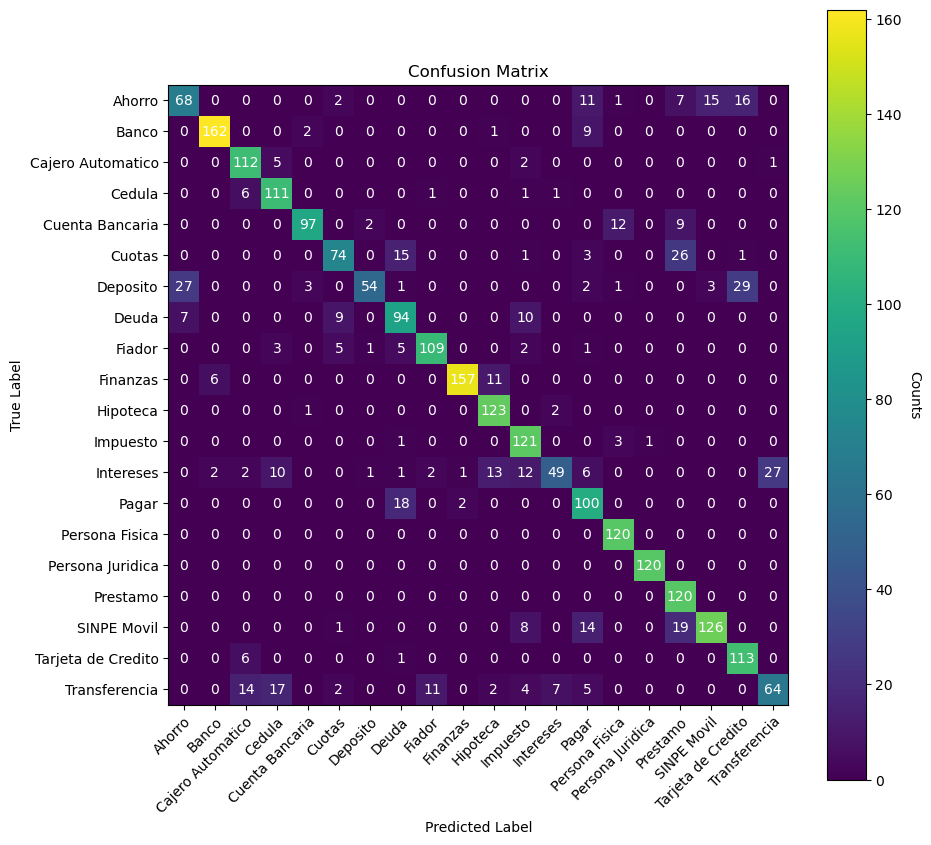

In [9]:
import matplotlib.pyplot as plt

confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)
for i in range(len(y_pred)):
    confusion_matrix[y_true_cat[i], y_pred_cat[i]] += 1

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(confusion_matrix)

# Set labels for ticks and axis
ax.set_xticks(np.arange(n_classes))
ax.set_yticks(np.arange(n_classes))
ax.set_xticklabels(all_classes, rotation=45, ha="right")
ax.set_yticklabels(all_classes)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(n_classes):
    for j in range(n_classes):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="w")

# Set a title for the plot
ax.set_title("Confusion Matrix")

# Add a colorbar legend
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Counts", rotation=-90, va="bottom")

plt.show()